# Noise induced regularization

## What is overfitting?

Machine learning (ML) usually requires highly flexible models with lots of trainable parameters in order to *learn* a certain underlying function (or data distribution) throughout an optimization process. 

However, being able to learn with low in-sample error is not enough: it is also desirable to have a model capable of high *generalization*, meaning that it is able of providing good predictions on previously unseen data.

Highly expressive model may incurr in the so called ***overfitting*** phenomenon, which means that they are trained too well on the training data, and as a result, performs poorly on new, unseen data.  

This happens because the model has learnt the noise in the training data, rather than the underlying pattern that is generalizable to new data.



## Quantum noise reduces overfitting

In this tutorial we will exploit quantum noise to avoid overfitting. 

In [1]:
import os

import jax  # require for Just In Time (JIT) compilation

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp


seed = 12345
np.random.seed(seed=seed)

### The circuit



We define the hyperparameters of our QNN, namely the number of qubits, the number of layers, the number of sublayers in the variational ansatz (`inner_layers`) and the resulting number of parameters per layer:

In [2]:
## we just set some values for layers and noise to check that everything works

design = "paper_model"

layers_draw = 2  # layers in the QNN we show
p = 0.01  # noise intensity
noise_type = "depolarizing "

Now we define the embedding of classical data and the variational anstaz that will then be combined to construct our QNN.

In [3]:
def create_circuit(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    if p == 0.0:
        key = jax.random.PRNGKey(12345)
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

    def embedding(x, layer, wires):
        # assert len(x)==1
        for i, wire in enumerate(wires):
            qml.RY((x[i % len(x)]), wires=wire)
        for i, wire in enumerate(wires):
            qml.RZ((x[i % len(x)] ** 2), wires=wire)

    def var_ansatz(
        theta,
        wires,
        rotations=[qml.RX, qml.RZ, qml.RX],
        entangler=qml.CNOT,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        assert len(theta) == 3 * N
        wires = list(wires)

        # each inner layer can have a different rotation
        for in_lay, rot in enumerate(rotations):
            angles = theta[in_lay * N : (in_lay + 1) * N]

            for i, angle in enumerate(angles):
                rot(angle, wires=wires[i % N])
            for qb in wires[:-1]:
                entangler(wires=[wires[qb], wires[qb + 1]])

    @qml.qnode(device, interface="jax")
    def circuit(
        x,
        theta,
    ):
        # print(x)
        # print(theta)

        for i in range(layers):
            embedding(x, layer=i + 1, wires=range(n_qubits))
            qml.Barrier(only_visual=True)
            var_ansatz(
                theta[i * params_per_layer : (i + 1) * params_per_layer],
                wires=range(n_qubits),
                entangler=qml.CNOT,
            )
            qml.Barrier(only_visual=True)

        return qml.expval(qml.PauliZ(wires=0))  # we measure only the first qubit

    return circuit


def create_circuit_diabetes(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    if p == 0.0:
        key = jax.random.PRNGKey(12345)
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )  # shots=8192, prng_key=key
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

    def embedding(x, layer, wires):
        qml.RX((x[0]), wires=wires[0])
        qml.RX((x[1]), wires=wires[2])
        qml.Barrier(only_visual=True)

    def var_ansatz(
        theta,
        wires,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        wires = list(wires)

        for i, wire in enumerate(wires):
            qml.RY(theta[i], wires=wire)

        for i, wire in enumerate(wires):
            qml.IsingXX(theta[N + i], wires=[i, (i + 1) % N])

    @qml.qnode(device, interface="jax")
    def circuit(
        x,
        theta,
    ):
        for i in range(layers):
            embedding(x, layer=i + 1, wires=range(n_qubits))

            var_ansatz(
                theta[i * params_per_layer : (i + 1) * params_per_layer],
                wires=range(n_qubits),
            )

        return qml.expval(
            qml.PauliZ(wires=[0])
            @ qml.PauliZ(wires=[1])
            @ qml.PauliZ(wires=[2])
            @ qml.PauliZ(wires=[3])
        )  # we measure only the first qubit

    return circuit

In [4]:
# create the circuit with given number of qubits and layers
if design == "2design":
    n_qubits = 5
    inner_layers = 3
    qnn = create_circuit(
        n_qubits,
        layers_draw,
        p=p,
        noise_type=noise_type,
    )

elif design == "paper_model":  # QNN model from arXiv:2410.19921
    n_qubits = 4
    inner_layers = 2
    qnn = create_circuit_diabetes(
        n_qubits,
        layers_draw,
        p=p,
        noise_type=noise_type,
    )

params_per_layer = n_qubits * inner_layers

Let's have a look at single layer of our QNN:

(<Figure size 1700x500 with 1 Axes>, <Axes: >)

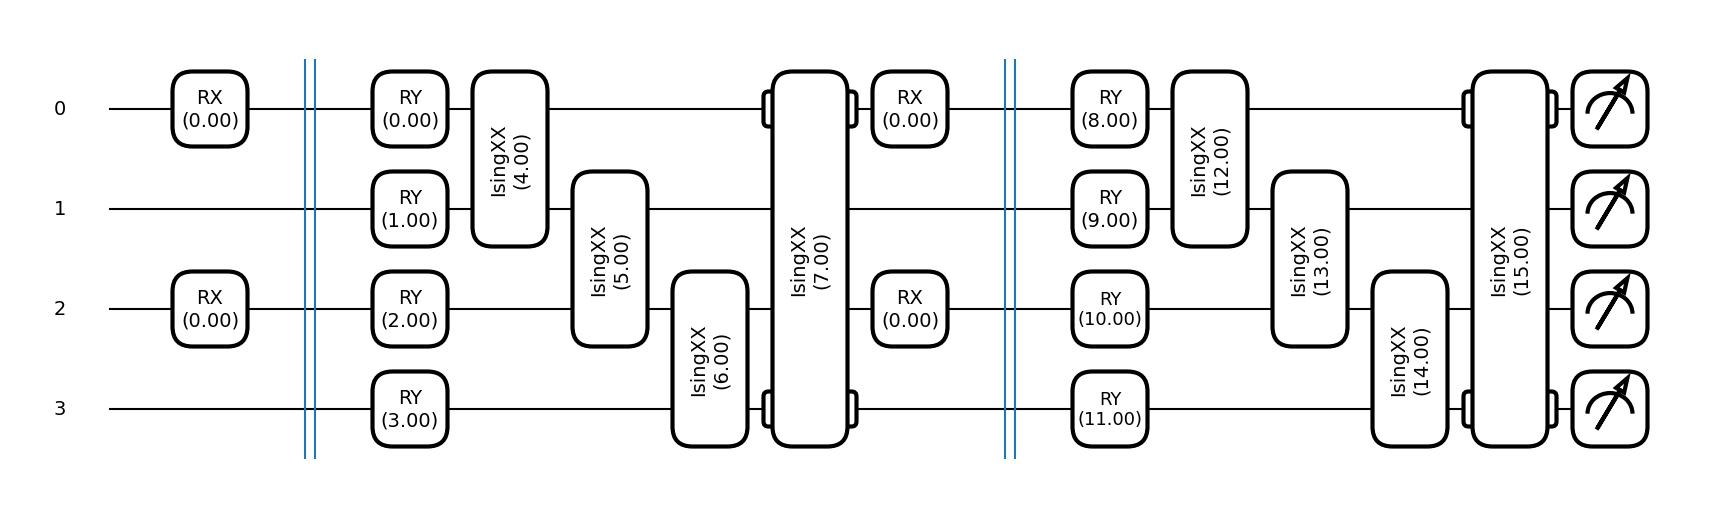

In [5]:
# we count the parameters
numbered_params = jnp.array(range(params_per_layer * layers_draw), dtype=float)
# we encode a single coordinate
single_sample = jnp.array([0])

qml.draw_mpl(
    qnn,
    decimals=2,
)(
    single_sample,
    numbered_params,
)

We now build the model that we will employ for the regression task with 10 layers and we exploit `JAX` to speed the training up:

In [6]:
from datasets import *

dataset = "diabetes"

if dataset == "sin":
    X_train, X_test, y_train, y_test = make_sin_dataset(dataset_size=50, test_size=0.7)

elif dataset == "sin2":
    X_train, X_test, y_train, y_test = make_sin_dataset(dataset_size=20, test_size=0.25)

elif dataset in ["diabetes", "diabetes2"]:
    X_train, X_test, y_train, y_test = make_diabetes_dataset(dataset)

removed elements: [365 382]


### Optimizer

In [7]:
optimizer = optax.adam(learning_rate=0.01)

# Training

In [ ]:
layers = 3

n_run = 10
epochs = 1000


noise_values = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)
if design == "paper_model":
    noise_values = np.concatenate(
        [noise_values, [10**i for i in np.linspace(-3, 0, 13)]]
    )
    noise_values = np.concatenate([noise_values, np.array([3, 5, 6, 8, 9]) * 1e-2])


for noise_type in ["depolarizing", "phase_damp", "ampl_damp"]:
    print(noise_type)

    ### checking if previous data already exist
    try:
        data_folder = (
            f"./data/regularization/{dataset}/{design}/{noise_type}/{layers}_layers"
        )
        train_history = np.load(
            data_folder + f"/train_loss_{n_run}.npy", allow_pickle=True
        )
        test_history = np.load(
            data_folder + f"/test_loss_{n_run}.npy", allow_pickle=True
        )
        opt_params = np.load(
            data_folder + f"/opt_params_{n_run}.npy", allow_pickle=True
        )
        train_history = train_history[()]
        test_history = test_history[()]
        opt_params = opt_params[()]
    except:
        train_history = {}
        test_history = {}
        opt_params = {}
    noise_values = list(filter(lambda x: x not in opt_params.keys(), noise_values))

    for p in noise_values:
        if design == "2design":
            n_qubits = 5
            inner_layers = 3
            qnn_tmp = create_circuit(
                n_qubits,
                layers,
                p=p,
                noise_type=noise_type,
            )

        elif design == "paper_model":  # QNN model from arXiv:2410.19921
            n_qubits = 4
            inner_layers = 2
            qnn_tmp = create_circuit_diabetes(
                n_qubits,
                layers,
                p=p,
                noise_type=noise_type,
            )

        qnn_tmp = jax.jit(qnn_tmp)
        qnn_batched = jax.vmap(
            qnn_tmp, (0, None)
        )  # we want to vmap on 0-axis of the first circuit param
        # in this way we process in parallel all the inputs
        # We jit for faster execution
        qnn = jax.jit(qnn_batched)  #

        @jax.jit
        def calculate_mse_cost(
            X,
            y,
            theta,
        ):
            yp = qnn(
                X,
                theta,
            )
            yp = jnp.array(yp).T

            cost = jnp.mean((yp - y) ** 2)

            return cost

        # Optimization update step
        @jax.jit
        def optimizer_update(
            opt_state,
            params,
            x,
            y,
        ):
            loss, grads = jax.value_and_grad(
                lambda theta: calculate_mse_cost(
                    x,
                    y,
                    theta,
                )
            )(params)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss

        costs_per_comb = []
        test_costs_per_comb = []
        opt_params_per_comb = []
        for tmp_seed in range(seed, seed + n_run):
            key = jax.random.PRNGKey(tmp_seed)

            assert len(X_train.shape) == 2
            assert len(y_train.shape) == 1
            assert X_train.shape[0] == y_train.shape[0]

            initial_params = jax.random.normal(key, shape=(layers * params_per_layer,))
            key = jax.random.split(key)[0]

            params = jnp.copy(initial_params)

            opt_state = optimizer.init(initial_params)

            costs = []
            test_costs = []

            for epoch in range(epochs):
                key = jax.random.split(key)[0]

                params, opt_state, cost = optimizer_update(
                    opt_state, params, X_train, y_train
                )

                ############## performance evaluation #############
                # inference is done with the original model
                # with all the gates

                cost = calculate_mse_cost(X_train, y_train, params)

                costs.append(cost)

                test_cost = 0

                if X_test is not None and y_test is not None:
                    test_cost = calculate_mse_cost(X_test, y_test, params)
                    test_costs.append(test_cost)
                if epoch % 50 == 0:
                    print(
                        f"NOISE: {p:.6f}",
                        f"run {tmp_seed-seed} - epoch {epoch}/{epochs}",
                        f"--- Train cost:{cost:.6f}--- Test cost:{test_cost:.6f}",
                        end="\r",
                    )

            costs_per_comb.append(costs)
            test_costs_per_comb.append(test_costs)
            opt_params_per_comb.append(params)
            print()
        costs_per_comb = np.array(costs_per_comb)
        test_costs_per_comb = np.array(test_costs_per_comb)
        opt_params_per_comb = np.array(opt_params_per_comb)

        train_history[p] = costs_per_comb
        test_history[p] = test_costs_per_comb
        opt_params[p] = opt_params_per_comb

        dir_path = "."  # os.path.dirname(absolute_path)

        data_folder = (
            f"./data/regularization/{dataset}/{design}/{noise_type}/{layers}_layers"
        )
        os.makedirs(data_folder, 0o755, exist_ok=True)

        np.save(data_folder + f"/train_loss_{n_run}.npy", train_history)
        np.save(data_folder + f"/test_loss_{n_run}.npy", test_history)
        np.save(data_folder + f"/opt_params_{n_run}.npy", opt_params)

# Plots

In [13]:
import os

import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns


sns.set()
sns.set_style("ticks")

In [ ]:
n_run = 10
epochs = 1000

noise_type = "depolarizing"
dataset = "diabetes"
design = "paper_model"  #'2design'#

noise_values = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)
if design == "paper_model":
    noise_values = np.concatenate(
        [noise_values, [10**i for i in np.linspace(-3, 0, 13)]]
    )
    noise_values = np.concatenate([noise_values, np.array([3, 5, 6, 8, 9]) * 1e-2])

layers = 5

dir_path = "."  # os.path.dirname(absolute_path)

data_folder = f"./data/regularization/{dataset}/{design}/{noise_type}/{layers}_layers"

## Plots not included in the paper

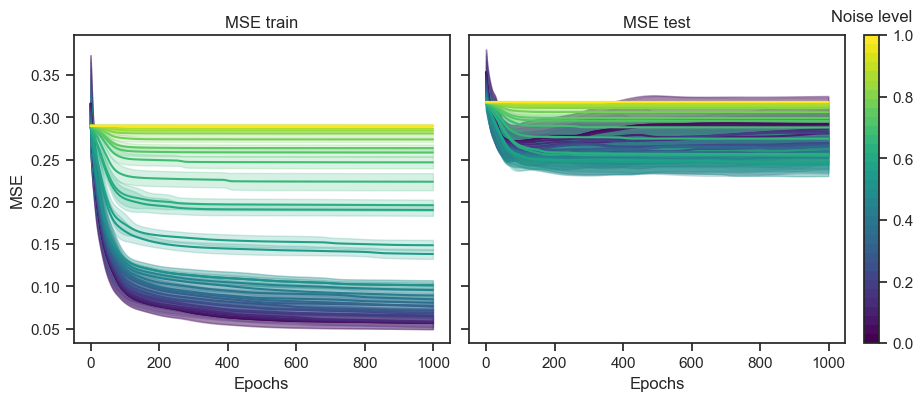

In [ ]:
train_history = np.load(data_folder + f"/train_loss_{n_run}.npy", allow_pickle=True)
test_history = np.load(data_folder + f"/test_loss_{n_run}.npy", allow_pickle=True)
opt_params = np.load(data_folder + f"/opt_params_{n_run}.npy", allow_pickle=True)


train_history = train_history[()]
test_history = test_history[()]
opt_params = opt_params[()]

selected = noise_values  ## you may want to reduce the noise levels plotted

cmap_1 = cm.get_cmap("viridis", len(train_history.items()))  #

index = 0

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)
axs[0].set_title("MSE train")


for i, (k, v) in enumerate(sorted(train_history.items())[:]):
    # if 1/371+3e-3 >= k >= 1/(4*371)-6e-4:
    if k in selected:
        train_losses = np.array(v)
        if layers == 4 or dataset == "sin2":
            train_losses = train_losses[:, :, index]
        mean_train_history = np.mean(train_losses, axis=0)[:epochs]
        std_train_history = np.std(
            train_losses,
            axis=0,
        )[:epochs]

        mean_train_history = mean_train_history.reshape((epochs,))
        std_train_history = std_train_history.reshape((epochs,))

        # shadow standard deviation
        axs[0].fill_between(
            range(epochs),
            mean_train_history - std_train_history,
            mean_train_history + std_train_history,
            alpha=0.2,
            color=cmap_1(i),
        )
        # average trend
        axs[0].plot(
            range(epochs), mean_train_history, label=f"{k:.2g}", color=cmap_1(i)
        )  # Avg Loss


axs[1].set_title("MSE test")

for i, (k, v) in enumerate(sorted(test_history.items())[:]):
    # if 1/371+3e-3 >= k >= 1/(4*371)-6e-4:
    if k in selected:
        test_losses = np.array(v)
        if layers == 4 or dataset == "sin2":
            test_losses = test_losses[:, :, index]
        mean_test_history = np.mean(test_losses, axis=0)[:epochs]
        std_test_history = np.std(
            test_losses,
            axis=0,
        )[:epochs]

        mean_test_history = mean_test_history.reshape((epochs,))
        std_test_history = std_test_history.reshape((epochs,))

        # shadow standard deviation
        axs[1].fill_between(
            range(epochs),
            mean_test_history - std_test_history,
            mean_test_history + std_test_history,
            alpha=0.2,
            color=cmap_1(i),
        )
        # averange trend
        axs[1].plot(
            range(epochs), mean_test_history, label=f"{k:.2g}", color=cmap_1(i)
        )  # Avg Loss


# Normalize and create a ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=min(selected), vmax=max(selected))
sm = plt.cm.ScalarMappable(cmap=cmap_1, norm=norm)
sm.set_array([])  # Required for colorbar

# Add a single colorbar for the figure
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation="vertical", pad=0.02)
cbar.ax.set_title("Noise level", fontsize=12, pad=10)  # this places title above

for ax in axs.flat:
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE")
    # ax.set_yscale('log')
    # ax.set_ylim([-0.01, 0.5])
    ax.label_outer()

p* :  0.5623413251903491


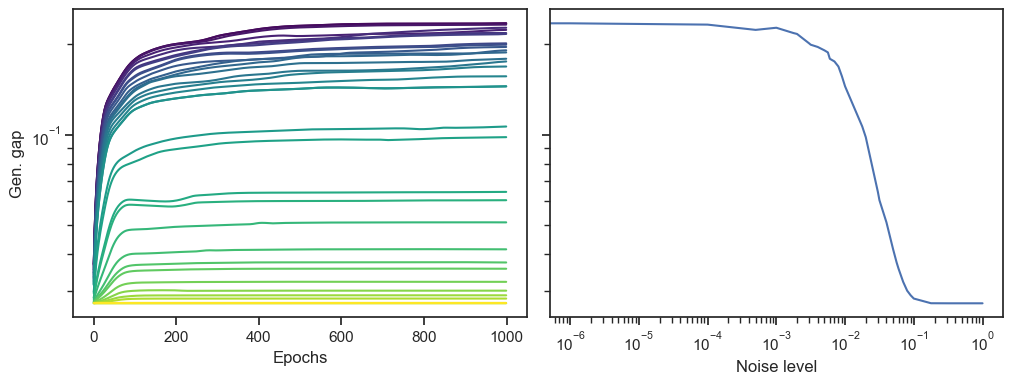

In [ ]:
train_history = np.load(data_folder + f"/train_loss_{n_run}.npy", allow_pickle=True)
test_history = np.load(data_folder + f"/test_loss_{n_run}.npy", allow_pickle=True)
opt_params = np.load(data_folder + f"/opt_params_{n_run}.npy", allow_pickle=True)


train_history = train_history[()]
test_history = test_history[()]
opt_params = opt_params[()]

## you may want to reduce the noise levels plotted
selected = noise_values

cmap_1 = cm.get_cmap("viridis", len(train_history.items()))  #

index = 0

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)

gen_gap_list = []
noizzz = []
for i, (k, v) in enumerate(sorted(train_history.items())[:]):
    # if 1/371+3e-3 >= k >= 1/(4*371)-6e-4:
    if k in selected:
        noizzz.append(k)
        train_losses = np.array(v)
        test_losses = np.array(test_history[k])

        if layers == 4 or dataset == "sin2":
            train_losses = train_losses[:, :, index]
            test_losses = test_losses[:, :, index]

        train_norm_factor = train_losses[:, 0] - train_losses[:, epochs - 1]
        test_norm_factor = test_losses[:, 0] - test_losses[:, epochs - 1]
        # train_losses = list(map(lambda x: train_losses[x]/train_norm_factor[x], range(n_run)))
        # test_losses = list(map(lambda x: test_losses[x]/train_norm_factor[x], range(n_run)))

        # train
        mean_train_history = np.mean(train_losses[:, :epochs], axis=0)
        std_train_history = np.std(
            train_losses[:, :epochs],
            axis=0,
        )

        mean_train_history = mean_train_history.reshape((epochs,))
        std_train_history = std_train_history.reshape((epochs,))

        # test
        mean_test_history = np.mean(test_losses[:, :epochs], axis=0)
        std_test_history = np.std(
            test_losses[:, :epochs],
            axis=0,
        )

        mean_test_history = mean_test_history.reshape((epochs,))
        std_test_history = std_test_history.reshape((epochs,))

        gen_gaps = np.abs(mean_test_history - mean_train_history)
        gen_gap_list.append(gen_gaps[-1])
        axs[0].plot(
            range(epochs), gen_gaps, label=f"{k:.2g}", color=cmap_1(i)
        )  # Avg Loss


axs[1].plot(noizzz, gen_gap_list)
print("p* : ", noizzz[np.argmin(gen_gap_list)])

# Normalize and create a ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=min(selected), vmax=max(selected))
sm = plt.cm.ScalarMappable(cmap=cmap_1, norm=norm)
sm.set_array([])  # Required for colorbar

# Add a single colorbar for the figure
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation="vertical", pad=0.02)
cbar.ax.set_title("Noise level", fontsize=12, pad=10)  # this places title above

axs[1].set_xscale("log")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Noise level")
axs[0].set_ylabel("Gen. gap")
axs[0].set_yscale("log")
# axs.set_ylim([-0.01, 0.5])
axs[0].label_outer()

## Plots included in the paper

#### Comparing $p^*$ from NID and MSE 

In [22]:
from tools import gather_QFIMs_eigvals_diff_noise, find_R_max, I_r_trend_truncated

n_run = 10
epochs = 1000

dir_path = "."  # os.path.dirname(absolute_path)

noise_values = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)  #

dataset = "sin2"  # 'diabetes2' # 'sin2' #
design = "2design"  # 'paper_model' #
noise_type = "ampl_damp"
layers = 10

print(dataset, noise_type, layers, design)


# for dataset in ['sin2', 'sin', 'diabetes', 'uniform', 'random']:
if design == "2design":
    n_qubits = 5
    inner_layers = 3
    if dataset == "regr_moons":
        noise_values = np.concatenate([noise_values, [0.1, 0.3, 0.5, 0.7, 1]])
elif design == "paper_model":
    n_qubits = 4
    inner_layers = 2
    noise_values = np.concatenate(
        [noise_values, [10**i for i in np.linspace(-3, 0, 13)]]
    )[:]
    noise_values = np.concatenate([noise_values, np.array([3, 5, 8, 9]) * 1e-2])


params_per_layer = inner_layers * n_qubits

##### QFIM analysis
data_folder_overp = (
    dir_path + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers/QFIMs"
)


# creating a dictionary gathering all noise levels
gather_eigvs = gather_QFIMs_eigvals_diff_noise(noise_values, dataset, data_folder_overp)

## we determin R_max,
## the index separating the eigenvalues that can grow from the one that are supppressed
R_max = find_R_max(noise_values, gather_eigvs)

## removing noiseless case
noise_values_plotting = sorted(noise_values)[1:]

## compute I_r only for the eigenvalues that can grow
increases_list, mean_increase, std_increase = I_r_trend_truncated(
    gather_eigvs, R_max, noise_values_plotting
)

### increases_list has shape = (noise_values, R_max)

## computing p* inducing the best NIE
opt_p_list_qfim = []
for I_r_runs in np.array(
    increases_list, dtype=object
).T:  # per each eigenval r we have multiple runs with different values of p
    ## np.array(increases_list).T.shape = (eigenvals, inputs x runs, noise_levels)

    tmp = list(map(lambda x: noise_values_plotting[np.nanargmax(x)], I_r_runs))
    opt_p_list_qfim.append(tmp)

mean_p_qfim = np.mean(opt_p_list_qfim)
std_p_qfim = np.std(opt_p_list_qfim)
print()
print(dataset, rf"p* from QFIM: {mean_p_qfim:.4f} ± {std_p_qfim:.4f}")


#####################
#### MSE
####################

data_folder = f"./data/regularization/{dataset}/{design}/{noise_type}/{layers}_layers"

train_history = np.load(data_folder + f"/train_loss_{n_run}.npy", allow_pickle=True)[()]
test_history = np.load(data_folder + f"/test_loss_{n_run}.npy", allow_pickle=True)[()]


## possible reduction of noise levels plotted
selected = sorted(noise_values)  # np.array(sorted(list(train_history.keys())))#

avg_train = []
avg_test = []

error_train = []
error_test = []

train_mse_list = []
test_mse_list = []

for k in selected:
    train_losses = np.array(train_history[k])
    test_losses = np.array(test_history[k])

    # if (layers == 4 and dataset=='sin') or (dataset in ['sin2', 'diabetes2'] and design=='2design'):

    train_losses = train_losses[:, :epochs][:, -1]
    test_losses = test_losses[:, :epochs][:, -1]

    ## train

    train_mse_list.append(train_losses)

    mean_train_history = np.mean(train_losses, axis=0)
    std_train_history = np.std(
        train_losses,
        axis=0,
    )

    avg_train.append(mean_train_history)
    error_train.append(std_train_history)

    ## test

    test_mse_list.append(test_losses)

    mean_test_history = np.mean(test_losses, axis=0)
    std_test_history = np.std(
        test_losses,
        axis=0,
    )

    avg_test.append(mean_test_history)
    error_test.append(std_test_history)


## determining opt p* per each run
## p* can be gen. gap=0 or dip in test error,

train_mse_list = np.array(train_mse_list)
test_mse_list = np.array(test_mse_list)

list_gen_gaps = np.abs(train_mse_list - test_mse_list)
list_argmin_gen_gap = list(map(lambda x: selected[np.nanargmin(x)], list_gen_gaps.T))

list_argmin_test_mse = list(map(lambda x: selected[np.nanargmin(x)], test_mse_list.T))

mean_p_gap = np.mean(list_argmin_gen_gap)
std_p_gap = np.std(list_argmin_gen_gap)

mean_p_test_mse = np.mean(list_argmin_test_mse)
std_p_test_mse = np.std(list_argmin_test_mse)

mean_p_mse = mean_p_test_mse
std_p_mse = std_p_test_mse


print()
print(
    f"from gap {mean_p_gap:.4f} ± {std_p_gap:.4f}, from test mse {mean_p_test_mse:.4f} ± {std_p_test_mse:.4f}"
)
print(rf"p* from MSE: {mean_p_mse:.4f} ± {std_p_mse:.4f}")

sin2 ampl_damp 10 2design

sin2 p* from QFIM: 0.0031 ± 0.0004

from gap 0.0033 ± 0.0005, from test mse 0.0026 ± 0.0005
p* from MSE: 0.0026 ± 0.0005


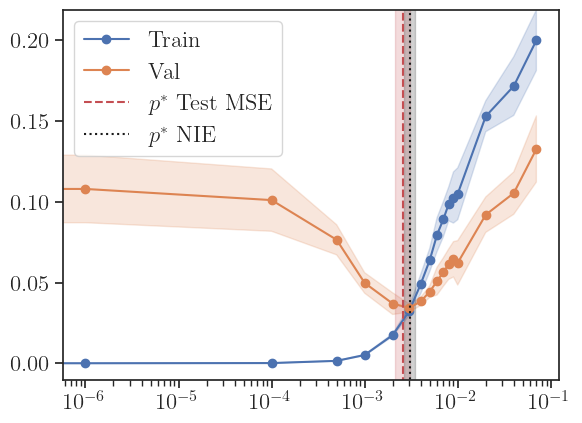

In [34]:
### PLOT

sns.set(font_scale=1.5, style="ticks")
import matplotlib as mpl
from matplotlib.transforms import ScaledTranslation

# setting up latex fontsyle
mpl.pyplot.rc("text", usetex=True)
mpl.pyplot.rcParams.update({"text.usetex": True})
mpl.pyplot.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.sans-serif": "Computer Modern"}
)


avg_train = np.array(avg_train)
avg_test = np.array(avg_test)


error_train = np.array(error_train)
error_test = np.array(error_test)


fig, ax = plt.subplots()

ax.plot(
    selected, avg_train, label="Train", marker="o", color=sns.color_palette("deep")[0]
)
ax.plot(selected, avg_test, label="Val", marker="o", color=sns.color_palette("deep")[1])
# ax.plot(selected, avg_exp, label='Val+train w',  marker='o',color=sns.color_palette('deep')[2], linestyle='dotted')

# shadow standard deviation
ax.fill_between(
    selected,
    avg_train - error_train,
    avg_train + error_train,
    alpha=0.2,
    color=sns.color_palette("deep")[0],
)

ax.fill_between(
    selected,
    avg_test - error_test,
    avg_test + error_test,
    alpha=0.2,
    color=sns.color_palette("deep")[1],
)


plt.vlines(
    mean_p_test_mse,
    -0.02,
    0.45,
    linestyle="dashed",
    color=sns.color_palette("deep")[3],
    label=r"$p^*$ Test MSE",
)
plt.fill_betweenx(
    [-0.02, 0.45],
    mean_p_test_mse - std_p_test_mse,
    mean_p_test_mse + std_p_test_mse,
    color=sns.color_palette("deep")[3],
    alpha=0.2,
)
plt.vlines(
    np.mean(opt_p_list_qfim),
    -0.02,
    np.nanmax(mean_increase + std_increase) * 2,
    linestyle="dotted",
    color="k",
    label=r"$p^*$ NIE",
)

plt.fill_betweenx(
    [-0.02, np.nanmax(mean_increase + std_increase) * 2],
    mean_p_qfim - std_p_qfim,
    mean_p_qfim + std_p_qfim,
    color="k",
    alpha=0.2,
)


plt.xscale("log")
plt.ylim(-0.01, np.min(avg_train) + np.max(avg_train) + np.max(error_train))
plt.legend()